University of Michigan - ROB 101 Computational Linear Algebra

# Soft Margin Classifier

In [1]:
using Pkg
Pkg.add("OSQP")
Pkg.add("Compat")

   Updating registry at `~/.julia/registries/General`


   Updating git-repo `https://github.com/JuliaRegistries/General.git`


    Fetching: [===========================>             ]  

Fetching: [========================================>]  100.0 %

  Resolving package versions...
   Updating `~/.julia/environments/v1.4/Project.toml`
 [no changes]
   Updating `~/.julia/environments/v1.4/Manifest.toml`
 [no changes]
  Resolving package versions...
   Updating `~/.julia/environments/v1.4/Project.toml`
 [no changes]
   Updating `~/.julia/environments/v1.4/Manifest.toml`
 [no changes]


**Soft Margin RBF Classifier**

\begin{split}\begin{array}{ll}
  \mbox{minimize}_{\xi,w} & \frac{1}{2} \xi^\top \xi + \frac{\lambda}{2} w^\top w \\
  \mbox{subject to} & y_i (w^\top \phi_i) \geq 1 - \xi_i \qquad i = 1,\dots,n
\end{array}\end{split}

We can write this as

\begin{split}\begin{array}{ll}
  \mbox{minimize}_{\xi,w} & \frac{1}{2} \begin{bmatrix} w \\ \xi \end{bmatrix}^\top \begin{bmatrix} \lambda I_m & 0_{m\times n} \\ 0_{n\times m} & I_n \end{bmatrix} \begin{bmatrix} w \\ \xi \end{bmatrix} \\
  \mbox{subject to} & \begin{bmatrix} -\infty_n \\ 0_n \end{bmatrix} \leq \begin{bmatrix} \Phi_{n\times m} & -I_n \\ 0_{n\times m} & I_n \end{bmatrix} \begin{bmatrix} w \\ \xi \end{bmatrix} \leq \begin{bmatrix} -1_n \\ \infty_n \end{bmatrix}
\end{array}\end{split}

where now $m = n + 1$, 
$$ \Phi_{n\times m} = \begin{bmatrix} -y_1 \phi_1^\top \\ \vdots \\ -y_n \phi_n^\top \end{bmatrix}.$$


In [2]:
# generate a dataset
n = 200; # number data points
stop = false;
k1 = 0; # number of 1
k2 = 0; # number of -1
X = zeros(n,2); # input matrix
t = zeros(n,1); # target values
i = 1;
while !stop
    x = rand(1,2) * 10.;
    y = (x[1]-5)^2 + (x[2]-5)^2;
    # generate target values
    if (y < 5.5) && k1 < n/2
        t[i] = 1;
        X[i,:] = x;
        k1 += 1;
        i += 1;
    elseif (y > 4) && k2 < n/2
        t[i] = -1;
        X[i,:] = x;
        k2 += 1;
        i += 1;
    elseif k1 > (n/2-1) && k2 > (n/2-1)
        break;
    end
end

# Class +1 IDs
class1_id = t .== 1;

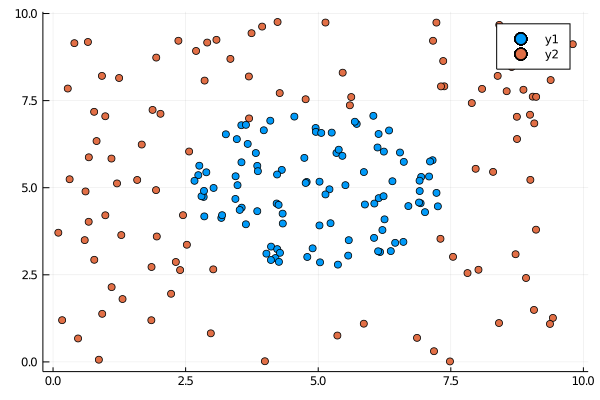

In [3]:
using Plots
gr() # Set the backend to GR

plot(X[class1_id[:],1], X[class1_id[:],2], seriestype = :scatter)
plot!(X[.!class1_id[:],1], X[.!class1_id[:],2], seriestype = :scatter)

In [4]:
using LinearAlgebra 

# Radial basis function
s = 1;
rbf(x, z, s) = exp.(-norm(x-z)^2 / (2*s^2));

function calc_phi_row(x, z, s)
    
    phi_row_size = size(z, 1) + 1
    phi_row = Array{Float64, 1}(undef, phi_row_size)
    phi_row[1] = 1
    
    for i in 2:phi_row_size
        phi_row[i] = rbf(x, z[i-1, :], s)
    end
    
    return phi_row
end

function regressor_matrix(X, centers, s)
    
    N = size(X, 1)
    M = size(centers, 1)
    phi = Array{Float64, 2}(undef, N, M+1)
    
    for i in 1:N
        phi[i, :] = calc_phi_row(X[i, :], centers, s)'
    end
    
    return phi
end

regressor_matrix (generic function with 1 method)

In [5]:
using OSQP
using SparseArrays

# Define problem data
m = n+1;
λ = 1; # tunable parameter (called hyperparameter because it's not like w the parameter of our model)
P = sparse([λ*(zeros(m,m) + I) zeros(m,n); zeros(n,m) (zeros(n,n) + I)]);
q = zeros(n+m,1);
Phi = regressor_matrix(X,X,s);
A = sparse([-t.*Phi -(zeros(n,n) + I); zeros(n,m) (zeros(n,n) + I)])
l = [zeros(n,1) .- Inf; zeros(n,1)];
u = [-ones(n,1); zeros(n,1) .+ Inf];

# Crate OSQP object
prob = OSQP.Model()

# Setup workspace and change alpha parameter
OSQP.setup!(prob; P=P, q=q[:], A=A, l=l[:], u=u[:])

# Solve problem
results = OSQP.solve!(prob);

println(results.x)

[-0.818382966952391, -0.03574493372688492, -0.14931746406674645, -0.05020020145005335, -0.030683010520038162, -0.027480811763157503, -0.0664732473700192, 0.039400929654719946, -0.1732200559178427, 0.19996384801570888, -0.04061692656829097, -0.017863381161087814, -0.040677351321611474, -0.029481288904100844, -0.18501072545384384, -0.15229420135796917, -0.020038680173526467, -0.03920017110020964, -0.061513574213106034, -0.07650740629427097, -0.04423490537838205, -0.04574904294919928, 0.10670879142634565, 0.005887314025174929, 0.1934440089515141, -0.08766734765465871, -0.28417066911121625, -0.16091786795839835, -0.19895477176928855, -0.15533635716836036, -0.029823422403649297, -0.08122190339380415, 0.13182879545733525, -0.028045054134711717, -0.19356710419450035, -0.0550289014855863, -0.013643492162007668, 0.19053657371266447, -0.03033266620885743, -0.10565555311514782, -0.14101066320014757, 0.1790864132263167, -0.01302214816427023, -0.19462464289796427, -0.04627601268283027, 0.1720293863

In [12]:
# create test data
x1 = 0:0.1:10;
x2 = 0:0.1:10;
X1 = zeros(length(x2),length(x1));
X2 = zeros(length(x2),length(x1));
for j=1:length(x1)
    for i=1:length(x2)
        X1[i,j]= x1[j]
        X2[i,j]= x2[i]
    end
end
X_test = [X1[:] X2[:]];
# get model weights
α = results.x[1:201,:]
# query
Phi_test = regressor_matrix(X_test,X,s);
Y_test = Phi_test * α;

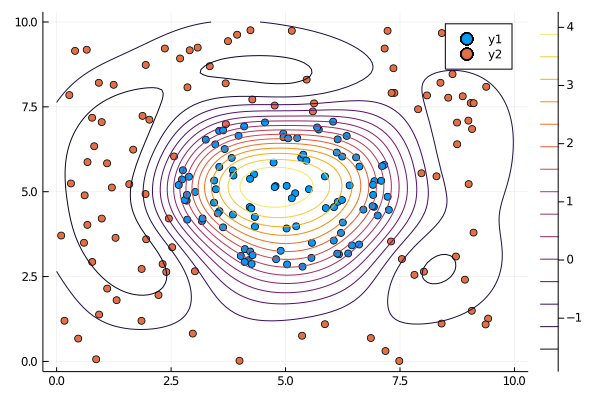

In [13]:
Z = reshape(Y_test, (length(x2), length(x1)));
# plot the margins
contour!(x1,x2,Z)

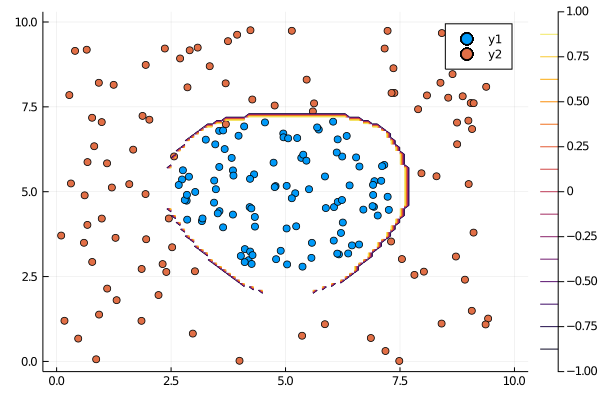

In [17]:
plot(X[class1_id[:],1], X[class1_id[:],2], seriestype = :scatter)
plot!(X[.!class1_id[:],1], X[.!class1_id[:],2], seriestype = :scatter)

Z = sign.(reshape(Y_test, (length(x2), length(x1))));
# plot the margins
contour!(x1,x2,Z)